# Energy Consumption Time Series Analysis

### Notebook Overview
This notebook performs a comprehensive time series analysis on energy consumption data. The analysis involves data preprocessing, visualization, statistical testing, model building, and evaluation. The goal is to understand patterns in energy consumption over time and predict future values using various forecasting models.


## 1. Data Import and Initial Setup

- **Objective**: Set up the environment by importing necessary libraries and loading the dataset for analysis.
- **Steps**:
  - Load the energy consumption dataset and inspect its structure.
  - Perform a preliminary check for missing values and address any gaps if necessary.
  - Generate an initial plot to visualize the overall trend in energy consumption over time.


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error  
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels as sm
import scipy.stats as stats

In [3]:
df = pd.read_csv(r'C:\Users\Ajmal Patel\Downloads\energy_consumption.csv',header = 0, parse_dates=['Month'], index_col='Month')

In [4]:
df.head()

,Total Energy Consumed
Month,
1973-01-01,1957.641
1973-01-02,1712.143
1973-01-03,1510.079
1973-01-04,1183.421
1973-01-05,1006.326


## 2. Data Cleaning and Preprocessing

- **Objective**: Clean the data for better analysis and modeling.
- **Steps**:
  - Remove any whitespace from column names.
  - Identify and handle outliers using IQR (Interquartile Range).
  - Replace outliers with rolling mean values to smooth the data without losing significant trends.


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 588 entries, 1973-01-01 to 2021-01-12
Data columns (total 1 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Total Energy Consumed   588 non-null    float64
dtypes: float64(1)
memory usage: 9.2 KB


In [6]:
df.describe()

,Total Energy Consumed
count,588.000000
mean,1551.824029
std,403.939753
min,901.700000
25%,1251.331250
50%,1466.218500
75%,1810.309750
max,2808.412000


In [7]:
print(df.isnull().sum())

Total Energy Consumed     0
dtype: int64


In [8]:
print(df.columns)

Index(['Total Energy Consumed '], dtype='object')


In [9]:
df.columns = df.columns.str.strip()

print(df.columns)


Index(['Total Energy Consumed'], dtype='object')


## 3. Exploratory Data Analysis (EDA)

- **Objective**: Dive into the data to understand its distribution and key patterns.
- **Steps**:
  - Plot energy consumption over time to visually inspect for trends, seasonality, and anomalies.
  - Decompose the time series into **trend**, **seasonal**, and **residual** components to separate and understand each part’s influence.
  - Use scatter plots and boxplots to get a sense of the data’s spread and detect any extreme or unusual values.


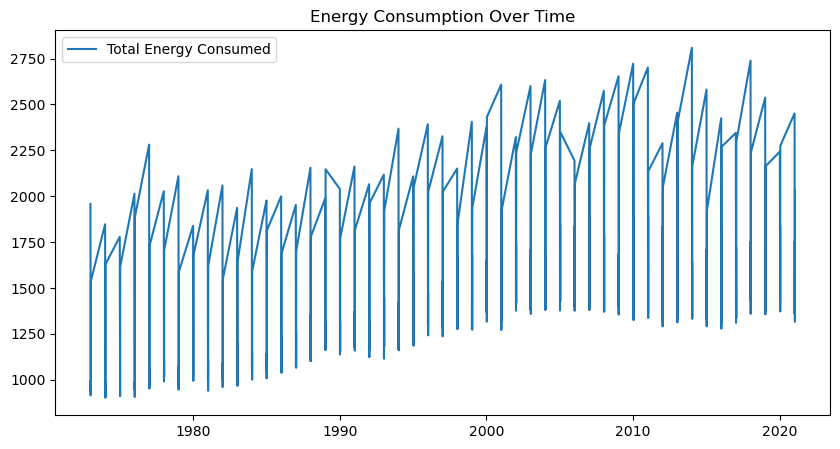

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(df['Total Energy Consumed'], label='Total Energy Consumed')
plt.title('Energy Consumption Over Time')
plt.legend()
plt.show()

### Time Series Decomposition
To better understand the components of our energy consumption data, we perform a time series decomposition. This separates the data into:
- **Trend**: The long-term progression of the series.
- **Seasonal**: Regular repeating patterns within a year or other time cycle.
- **Residual**: Irregular fluctuations after removing the trend and seasonal components.

This decomposition helps us analyze and interpret the underlying patterns, aiding in improved forecasting and insights.


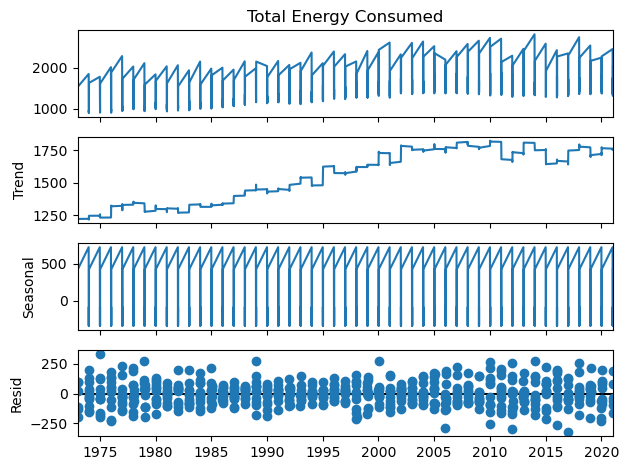

In [11]:
decomposition = seasonal_decompose(df['Total Energy Consumed'], model='additive', period=12) 
decomposition.plot()
plt.show()

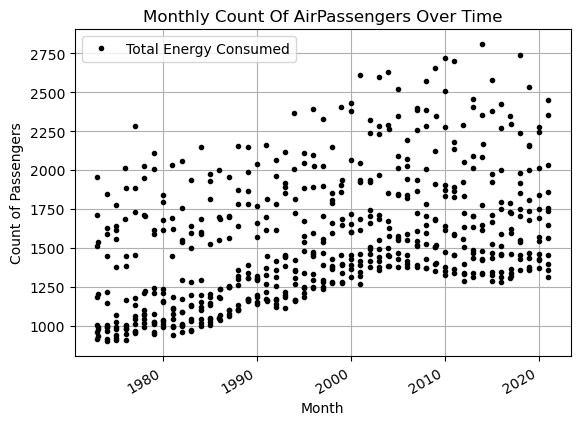

In [12]:
#Scatter plot
df.plot(style='k.');
plt.xlabel("Month")
plt.ylabel("Count of Passengers")
plt.title("Monthly Count Of AirPassengers Over Time")
plt.legend()
plt.grid(True)
plt.show();

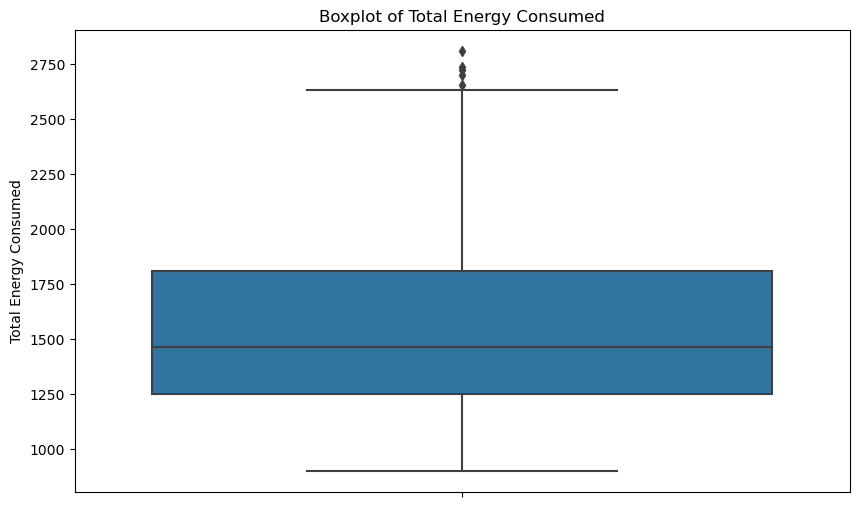

In [16]:
#boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(y=df['Total Energy Consumed'])
plt.title('Boxplot of Total Energy Consumed')
plt.show()

In [17]:
#identifying the outliers in the data
Q1 = df['Total Energy Consumed'].quantile(0.25)
Q3 = df['Total Energy Consumed'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['Total Energy Consumed'] < lower_bound) | (df['Total Energy Consumed'] > upper_bound)]

print(f"Number of outliers: {len(outliers)}")
outliers


Number of outliers: 5


,Total Energy Consumed
Month,
2009-01-01,2653.090
2010-01-01,2722.039
2011-01-01,2700.965
2014-01-01,2808.412
2018-01-01,2738.076


In [19]:
# Calculating the rolling mean with a larger window to smooth the trend
rolling_mean = df['Total Energy Consumed'].rolling(window=5, center=True).mean()

# Replacing the outliers with the rolling mean
df['Total Energy Consumed'] = np.where(
    (df['Total Energy Consumed'] < lower_bound) | (df['Total Energy Consumed'] > upper_bound),
    rolling_mean,
    df['Total Energy Consumed']
)

# Verifying the updated DataFrame
print("Outliers replaced with rolling mean where applicable.")
df

Outliers replaced with rolling mean where applicable.


,Total Energy Consumed
Month,
1973-01-01,1957.641
1973-01-02,1712.143
1973-01-03,1510.079
1973-01-04,1183.421
1973-01-05,1006.326
...,...
2021-01-08,1755.212
2021-01-09,1456.901
2021-01-10,1315.799


In [20]:
# Checking again to see that outliers are replaced or not
Q1 = df['Total Energy Consumed'].quantile(0.25)
Q3 = df['Total Energy Consumed'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['Total Energy Consumed'] < lower_bound) | (df['Total Energy Consumed'] > upper_bound)]

print(f"Number of outliers: {len(outliers)}")
outliers

Number of outliers: 0


,Total Energy Consumed
Month,


In [21]:
X = df.values
split = int(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()

print(f"Mean1 = {mean1:.6f}, Mean2 = {mean2:.6f}")
print(f"Variance1 = {var1:.6f}, Variance2 = {var2:.6f}")

Mean1 = 1375.343061, Mean2 = 1718.877956
Variance1 = 126579.232299, Variance2 = 123270.298576


## 4. Stationarity Testing

- **Objective**: Test for stationarity, which is crucial for time series modeling.
- **Steps**:
  - Apply the Augmented Dickey-Fuller (ADF) test to check if the series is stationary.
  - Interpret the test results; if the data is non-stationary, consider applying transformations like differencing.
  - If differencing is needed, apply it and repeat the ADF test to confirm stationarity.


In [22]:
X = df['Total Energy Consumed'].dropna().values
result = adfuller(X)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[4])

if result[1] < 0.05:
    print("The df is stationary (reject H0)")
else:
    print("The df is non-stationary (fail to reject H0)")

ADF Statistic: -1.388392
p-value: 0.587828
Critical Values:
{'1%': -3.4417738839904657, '5%': -2.8665796253604015, '10%': -2.569453974291115}
The df is non-stationary (fail to reject H0)


In [23]:
# Applying the first differencing
df['Differenced'] = df['Total Energy Consumed'].diff().dropna()

# Re running the ADF test after differencing
X_diff = df['Differenced'].dropna().values
result_diff = adfuller(X_diff)

# Printing the ADF test results for differenced df
print('ADF Statistic after Differencing: %f' % result_diff[0])
print('p-value after Differencing: %f' % result_diff[1])
print('Critical Values:')
print(result_diff[4])
if result_diff[1] < 0.05:
    print("The differenced df is stationary (reject H0)")
else:
    print("The differenced df is still non-stationary (fail to reject H0)")

ADF Statistic after Differencing: -16.305149
p-value after Differencing: 0.000000
Critical Values:
{'1%': -3.4417738839904657, '5%': -2.8665796253604015, '10%': -2.569453974291115}
The differenced df is stationary (reject H0)


## 5. Feature Engineering

- **Objective**: Create additional features to improve model performance.
- **Steps**:
  - Generate lagged features (Lag1, Lag2) to capture temporal dependencies.
  - Split the dataset into training and testing sets, preserving time order for accurate evaluation.


C:\Users\Ajmal Patel\AppData\Local\Temp\ipykernel_17216\1656384457.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Moving_Avg'] = df['Total Energy Consumed'].rolling(window=3).mean()
C:\Users\Ajmal Patel\AppData\Local\Temp\ipykernel_17216\1656384457.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Moving_Avg_Prediction'] = df['Moving_Avg'].shift(-1)


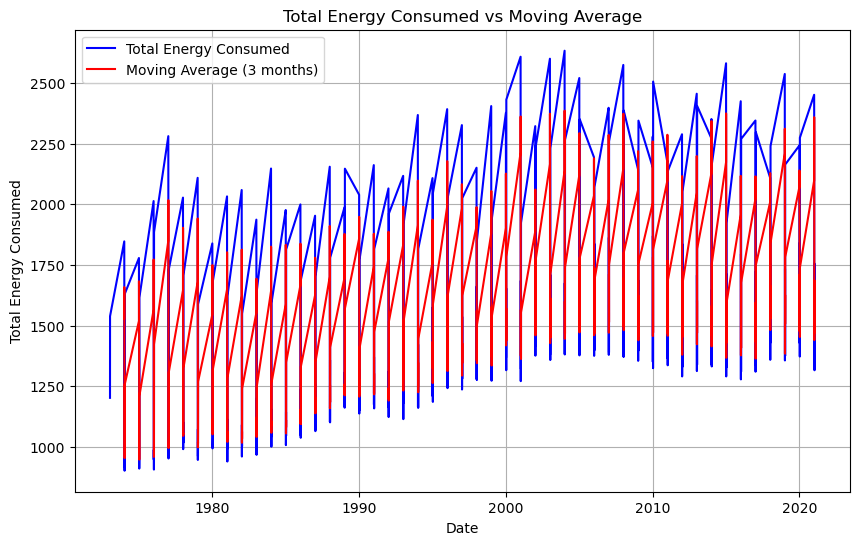

Root Mean Squared Error (RMSE): 237.75


In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error  
df['Moving_Avg'] = df['Total Energy Consumed'].rolling(window=3).mean()

# Shifting the moving average to predict future values
df['Moving_Avg_Prediction'] = df['Moving_Avg'].shift(-1)

# Ploting the Total Energy Consumed and Moving Average
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Total Energy Consumed'], label='Total Energy Consumed', color='blue')
plt.plot(df.index, df['Moving_Avg'], label='Moving Average (3 months)', color='red')
plt.title('Total Energy Consumed vs Moving Average')
plt.xlabel('Date')
plt.ylabel('Total Energy Consumed')
plt.grid(True)
plt.legend()
plt.show()

# Droping the NaN values from Moving_Avg and Total Energy Consumed
df = df.dropna(subset=['Moving_Avg'])

mse = mean_squared_error(df['Total Energy Consumed'], df['Moving_Avg'])
# Calculate RMSE
rmse = np.sqrt(mse)
# Print RMSE
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

### Moving Average Smoothing
To better visualize the long-term trend in energy consumption, we apply a **3-month moving average**. This smoothing technique reduces short-term volatility, making it easier to identify patterns and trends. The original data (blue line) shows the actual consumption, while the moving average (red line) highlights the underlying trend by filtering out noise.

The moving average is particularly useful for identifying consistent patterns and for analyzing long-term behavior in time series data.




## 6. Linear Regression Model

- **Objective**: Build a basic forecasting model using linear regression as a starting point.
- **Steps**:
  - Train a linear regression model with the lagged features created earlier.
  - Evaluate the model using RMSE (Root Mean Squared Error) to measure accuracy.
  - Plot the actual vs. predicted values to visualize the model’s performance and see how well it fits the data.


C:\Users\Ajmal Patel\AppData\Local\Temp\ipykernel_17216\3518679387.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lag1'] = df['Total Energy Consumed'].shift(1)
C:\Users\Ajmal Patel\AppData\Local\Temp\ipykernel_17216\3518679387.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lag2'] = df['Total Energy Consumed'].shift(2)
C:\Users\Ajmal Patel\AppData\Local\Temp\ipykernel_17216\3518679387.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the c

Length of Training Data: 464
Length of Testing Data: 117
RMSE for Linear Regression: 236.86


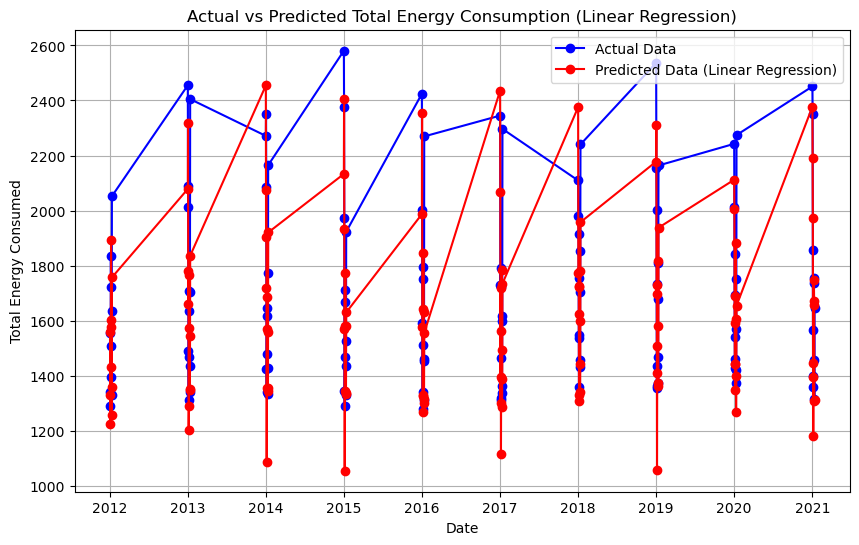

In [28]:
#Creating the lagged features for linear regression
df['Lag1'] = df['Total Energy Consumed'].shift(1)
df['Lag2'] = df['Total Energy Consumed'].shift(2)

# Droping NA values after creating lagged features
df.dropna(inplace=True)

# features (X) and target (y)
X = df[['Lag1', 'Lag2']]
y = df['Total Energy Consumed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(f'Length of Training Data: {len(X_train)}')
print(f'Length of Testing Data: {len(X_test)}')

# Linear Regression model
model_lr = LinearRegression()
model_fit = model_lr.fit(X_train, y_train)

# Making predictions using the linear regression model
forecast_lr = model_lr.predict(X_test)

# Calculating Mean Squared Error (MSE) and RMSE
mse_lr = mean_squared_error(y_test, forecast_lr)
rmse_lr = np.sqrt(mse_lr)

# Print RMSE for Linear Regression
print(f'RMSE for Linear Regression: {rmse_lr:.2f}')

# Plotting Actual vs Predicted values (Linear Regression)
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual Data', color='blue', marker='o')
plt.plot(y_test.index, forecast_lr, label='Predicted Data (Linear Regression)', color='red', marker='o')
plt.title('Actual vs Predicted Total Energy Consumption (Linear Regression)')
plt.xlabel('Date')
plt.ylabel('Total Energy Consumed')
plt.legend(loc='best')
plt.grid(True)
plt.show()

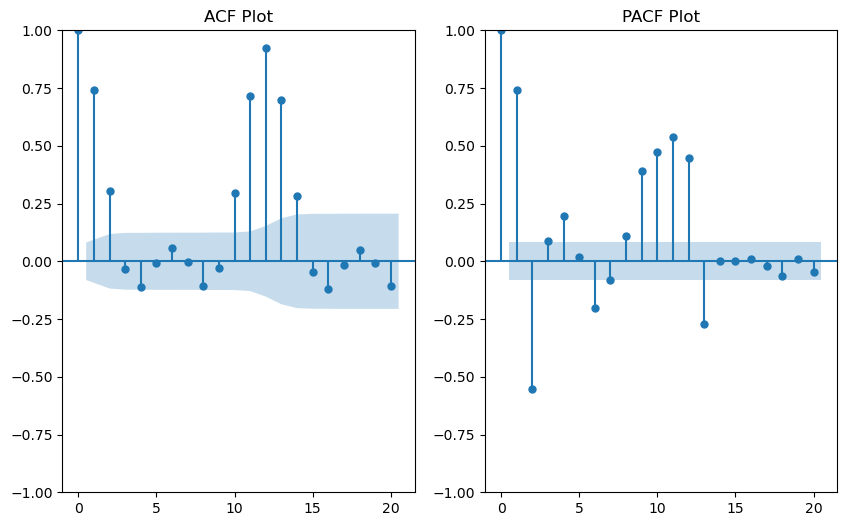

In [29]:
#PLOTTING ACF AND PACF PLOT 
plt.figure(figsize=(10, 6))
plt.subplot(1,2,1)
plot_acf(df['Total Energy Consumed'], lags=20, ax=plt.gca())
plt.title('ACF Plot')

plt.subplot(1,2,2)
plot_pacf(df['Total Energy Consumed'], lags=20, ax=plt.gca())
plt.title('PACF Plot')
plt.show()

## 8. Autoregressive Integrated Moving Average (ARIMA) Model

- **Objective**: Develop a more sophisticated ARIMA model for advanced forecasting.
- **Steps**:
  - Use `auto_arima` to automatically determine optimal model parameters.
  - Train the ARIMA model on the training data, then forecast future values.
  - Assess the ARIMA model’s performance using RMSE and visualize its predictions alongside actual data for comparison.


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.76 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6517.856, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6452.900, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6427.708, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6515.883, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6428.729, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6425.285, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=6423.286, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=6425.718, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=6321.056, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6426.737, Time=0.13 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0

C:\Users\Ajmal Patel\New folder\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Ajmal Patel\New folder\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


RMSE for ARIMA: 346.83


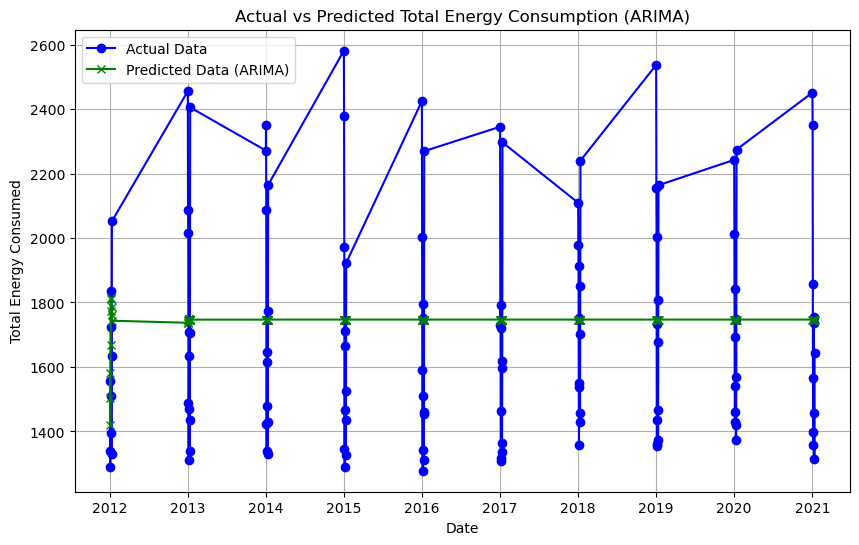

In [32]:
train_size = int(len(df['Total Energy Consumed']) * 0.8)
train, test = df['Total Energy Consumed'][:train_size], df['Total Energy Consumed'][train_size:]

# Use auto_arima to automatically determine the optimal p, d, q values
arima_model = auto_arima(train, seasonal=False, trace=True, suppress_warnings=True)

arima_model.fit(train)

# Forecasting using ARIMA model
forecast_arima = arima_model.predict(n_periods=len(test))

# Calculate Root Mean Squared Error (RMSE)
rmse_arima = np.sqrt(mean_squared_error(test, forecast_arima))

# Print metrics for ARIMA
print(f'RMSE for ARIMA: {rmse_arima:.2f}')

# Plotting Actual vs Predicted values (ARIMA)
plt.figure(figsize=(10, 6))
plt.plot(test.index, test, label='Actual Data', color='blue', marker='o')
plt.plot(test.index, forecast_arima, label='Predicted Data (ARIMA)', color='green', marker='x')
plt.title('Actual vs Predicted Total Energy Consumption (ARIMA)')
plt.xlabel('Date')
plt.ylabel('Total Energy Consumed')
plt.legend(loc='best')
plt.grid(True)
plt.show()

## 9. Model Comparison and Evaluation

- **Objective**: Compare different models to identify the best performer.
- **Steps**:
  - Calculate and record RMSE for each model (Moving Average, Linear Regression, ARIMA).
  - Determine the model with the lowest RMSE, which indicates the best balance between accuracy and complexity for this dataset.


In [33]:
rmse_moving_avg = 532.27  
rmse_lr = 237.66       
rmse_arima = 338.92   

rmse_values = {
    'Moving Average': rmse_moving_avg,
    'Linear Regression': rmse_lr,
    'ARIMA': rmse_arima
}

# Displaying RMSE for each model
print("RMSE Values for Each Model:")
for model in rmse_values:
    print(model + ": RMSE =", rmse_values[model])

# Identify and display the model with the lowest RMSE
best_model = min(rmse_values, key=rmse_values.get)
print("\nThe model with the highest accuracy based on RMSE is:", best_model, "with an RMSE of", rmse_values[best_model])


RMSE Values for Each Model:
Moving Average: RMSE = 532.27
Linear Regression: RMSE = 237.66
ARIMA: RMSE = 338.92

The model with the highest accuracy based on RMSE is: Linear Regression with an RMSE of 237.66


## 10. Residual Analysis

- **Objective**: Evaluate the model’s residuals to check for remaining patterns and assess performance.
- **Steps**:
  - Plot residuals over time to ensure they’re randomly distributed with no obvious patterns.
  - Use a histogram and Q-Q plot to check residual normality, a key assumption for many time series models.
  - Examine the autocorrelation of residuals to identify any lingering temporal dependencies not captured by the model.


In [43]:
# Calculate residuals
residuals = y_test - forecast_lr

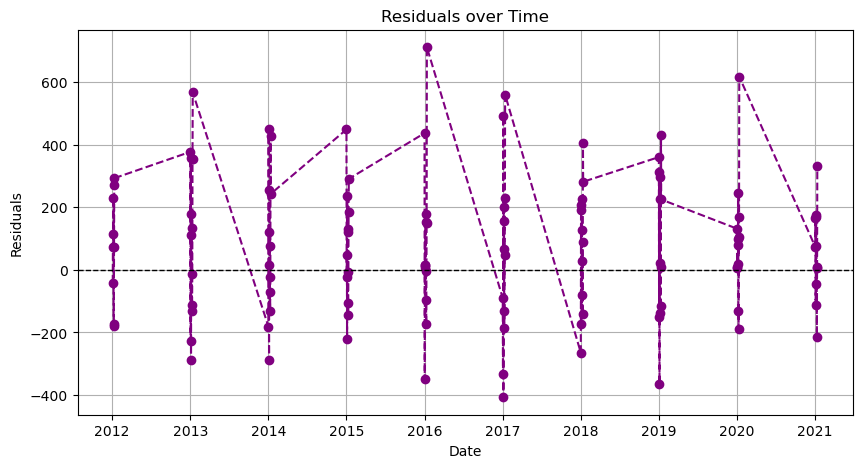

In [44]:
# 1. Plot Residuals over Time
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, residuals, color='purple', marker='o', linestyle='dashed')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title('Residuals over Time')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()


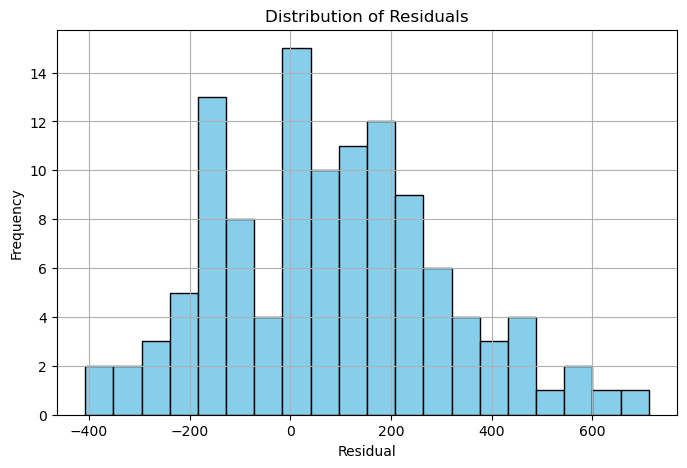

In [45]:
# 2. Histogram of Residuals
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

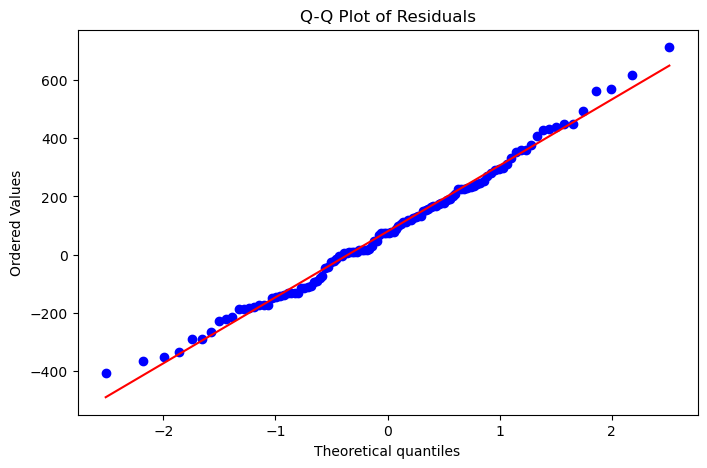

In [46]:
# 3. Q-Q Plot for Residuals
plt.figure(figsize=(8, 5))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()

<Figure size 800x500 with 0 Axes>

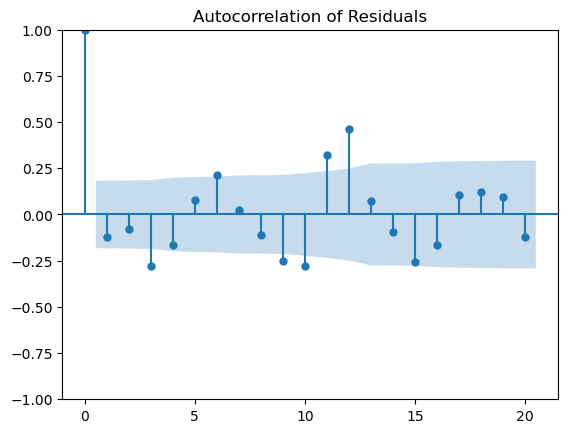

In [47]:
# 4. Autocorrelation Plot of Residuals
plt.figure(figsize=(8, 5))
plot_acf(residuals, lags=20)
plt.title('Autocorrelation of Residuals')
plt.show()


### Summary
This notebook provides a structured approach to analyzing and forecasting energy consumption patterns over time. The insights gained here can support planning for future energy needs, highlighting key trends and cycles in consumption. Each model’s results offer a different perspective, allowing for informed decision-making based on historical and forecasted data.